# SkinSight: Stage 2 - Disease Diagnosis Model (Fusion Ensemble)

## 🎯 Objective
Train a high-performance **Fusion Ensemble Model** (combining **ResNet50** and **InceptionV3**) to differentiate between skin conditions.

## 🩺 Classes
- **0: Melanoma** (Critical)
- **1: Tinea** (Benign)

## 🚀 Instructions
1. Ensure your dataset is in the `Dataset` folder with `Melanoma` and `Tinea` subfolders.
2. Run all cells to train the model.
3. result model will be saved as `models/fusion_ensemble.pth`.

In [8]:
# 1. Setup & Device Check
import os
import cv2
import numpy as np
import pandas as pd
import torch
# Fix for "partially initialized module" error in PyTorch 2.x
try:
    import torch._dynamo
    torch._dynamo.config.suppress_errors = True
except:
    pass

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Check for CUDA
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"✅ CUDA is Available: {torch.cuda.get_device_name(0)}")
    torch.backends.cudnn.benchmark = True # Enable optimization
else:
    device = torch.device('cpu')
    print("⚠️ CUDA not found. Training will be slow on CPU.")

✅ CUDA is Available: NVIDIA GeForce GTX 1650


In [9]:
# 2. Configuration & Validation
DATASET_DIR = 'Dataset'
CACHE_DIR = 'Dataset_Cache_Main'
BATCH_SIZE = 16
EPOCHS = 10  # Increased for higher accuracy
LEARNING_RATE = 1e-4

# Validate Dataset
expected_folders = ['Melanoma', 'Tinea']
for folder in expected_folders:
    path = os.path.join(DATASET_DIR, folder)
    if not os.path.exists(path):
        print(f"❌ Missing Dataset Folder: {path}")
        print("Please ensure 'Melanoma' and 'Tinea' folders exist in 'Dataset'.")
        raise FileNotFoundError(f"Missing {folder}")
    else:
        count = len(os.listdir(path))
        print(f"✅ Found {folder}: {count} images")

print("\n📁 Dataset structure validated.")

✅ Found Melanoma: 3140 images
✅ Found Tinea: 1702 images

📁 Dataset structure validated.


In [10]:
# 3. Advanced Preprocessing (Cached)
class Preprocessing:
    @staticmethod
    def process(image_np):
        # 1. Hair Removal
        gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (17, 17))
        blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
        _, mask = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
        image_np = cv2.inpaint(image_np, mask, 3, cv2.INPAINT_TELEA)
        
        # 2. CLAHE (Contrast Enhancement)
        lab = cv2.cvtColor(image_np, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        l = clahe.apply(l)
        image_np = cv2.cvtColor(cv2.merge((l,a,b)), cv2.COLOR_LAB2RGB)
        return image_np

print("🛠️ Preprocessing pipeline ready.")

🛠️ Preprocessing pipeline ready.


In [11]:
# 4. Fusion Dataset Definition (With Augmentation)
class SkinFusionDataset(Dataset):
    def __init__(self, file_paths, labels, train=False):
        self.file_paths = file_paths
        self.labels = labels
        self.train = train
        
        # Strong Augmentation for Training
        self.augment = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(20),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1))
        ])
        
        self.resize_res = transforms.Resize((224, 224))
        self.resize_inc = transforms.Resize((299, 299))
        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        os.makedirs(CACHE_DIR, exist_ok=True)

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        path = self.file_paths[idx]
        label = self.labels[idx]
        
        fname = f"{os.path.basename(os.path.dirname(path))}_{os.path.basename(path)}"
        cache_path = os.path.join(CACHE_DIR, fname)
        
        image = None
        if os.path.exists(cache_path):
            try:
                image = cv2.imread(cache_path)
                if image is not None: image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            except: pass
            
        if image is None:
            image = cv2.imread(path)
            if image is None:
                image = np.zeros((224, 224, 3), dtype=np.uint8)
            else:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = Preprocessing.process(image)
                cv2.imwrite(cache_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

        pil_img = Image.fromarray(image)
        
        # Apply Augmentation only if training
        if self.train:
            pil_img = self.augment(pil_img)

        res_in = self.normalize(self.to_tensor(self.resize_res(pil_img)))
        inc_in = self.normalize(self.to_tensor(self.resize_inc(pil_img)))
        return res_in, inc_in, label

In [12]:
# 5. Data Loading
def get_dataset(root_dir):
    cats = ['Melanoma', 'Tinea']
    files, labels = [], []
    for idx, cat in enumerate(cats):
        cat_path = os.path.join(root_dir, cat)
        for f in os.listdir(cat_path):
            files.append(os.path.join(cat_path, f))
            labels.append(idx)
    return train_test_split(files, labels, test_size=0.2, stratify=labels, random_state=42)

try:
    (train_X, test_X, train_y, test_y) = get_dataset(DATASET_DIR)
    train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.1, stratify=train_y, random_state=42)

    # Enable training augmentation for train_ds
    train_ds = SkinFusionDataset(train_X, train_y, train=True)
    val_ds = SkinFusionDataset(val_X, val_y, train=False)

    counts = np.bincount(train_y)
    weights = 1. / counts
    sample_weights = [weights[l] for l in train_y]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

    nw = 0 
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=nw, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=nw, pin_memory=True)
    
    # Detailed Counts
    train_counts = np.bincount(train_y)
    val_counts = np.bincount(val_y)
    
    print(f"📊 Training Data: {len(train_ds)} images")
    print(f"   - Melanoma (0): {train_counts[0]}")
    print(f"   - Tinea (1):    {train_counts[1]}")
    
    print(f"📊 Validation Data: {len(val_ds)} images")
    print(f"   - Melanoma (0): {val_counts[0]}")
    print(f"   - Tinea (1):    {val_counts[1]}")

except Exception as e:
    print(f"❌ Error loading data: {e}")

📊 Training Data: 3485 images
   - Melanoma (0): 2260
   - Tinea (1):    1225
📊 Validation Data: 388 images
   - Melanoma (0): 252
   - Tinea (1):    136


In [13]:
# 6. Fusion Model Architecture
class FusionEnsemble(nn.Module):
    def __init__(self, num_classes=2):
        super(FusionEnsemble, self).__init__()
        resnet = models.resnet50(weights='IMAGENET1K_V1')
        self.resnet_features = nn.Sequential(*list(resnet.children())[:-1])
        
        self.inception = models.inception_v3(weights='IMAGENET1K_V1')
        self.inception.aux_logits = False
        self.inception.fc = nn.Identity()
        
        self.classifier = nn.Sequential(
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Dropout(0.6), # Increased Dropout to prevent overfitting
            nn.Linear(1024, num_classes)
        )
        
    def forward(self, x_res, x_inc):
        f_res = self.resnet_features(x_res)
        f_res = f_res.view(f_res.size(0), -1)
        
        f_inc = self.inception(x_inc)
        if hasattr(f_inc, 'logits'): f_inc = f_inc.logits
        
        combined = torch.cat((f_res, f_inc), dim=1)
        return self.classifier(combined)

model = FusionEnsemble().to(device)
print("🧠 Model Initialized on GPU (with High Dropout)")

🧠 Model Initialized on GPU (with High Dropout)


In [14]:
# 7. Standard Training Loop
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
# Added weight_decay for regularization
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2, verbose=True)

history = {'loss': [], 'val_acc': []}
best_acc = 0.0
early_stop_counter = 0
EARLY_STOP_PATIENCE = 5

print(f"🚀 Starting Training for {EPOCHS} Epochs (w/ Regularization)...")

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    valid_batches = 0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    
    for x_res, x_inc, labels in pbar:
        x_res, x_inc, labels = x_res.to(device), x_inc.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(x_res, x_inc)
        loss = criterion(outputs, labels)
        
        if torch.isnan(loss):
            print("⚠️ NaN loss detected. Skipping batch.")
            continue
            
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        running_loss += loss.item()
        valid_batches += 1
        pbar.set_postfix({'loss': f"{loss.item():.4f}"})
        
    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x_res, x_inc, labels in val_loader:
            x_res, x_inc, labels = x_res.to(device), x_inc.to(device), labels.to(device)
            outputs = model(x_res, x_inc)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
    epoch_loss = running_loss / valid_batches if valid_batches > 0 else 0.0
    val_acc = 100 * correct / total
    history['loss'].append(epoch_loss)
    history['val_acc'].append(val_acc)
    
    scheduler.step(val_acc)
    
    print(f"   🏁 Epoch {epoch+1} Summary: Loss={epoch_loss:.4f}, Val Acc={val_acc:.2f}%")
    
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'models/fusion_ensemble.pth')
        print(f"   💾 Best Model Saved! ({best_acc:.2f}%)")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        
    if early_stop_counter >= EARLY_STOP_PATIENCE:
        print(f"🛑 Early Stopping triggered after {EARLY_STOP_PATIENCE} epochs of no improvement.")
        break

print("✨ Training Complete!")

🚀 Starting Training for 10 Epochs (w/ Regularization)...


E:\Final YR project\skinsight\backend\New folder\Skin_disease\venv_new\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10:   0%|          | 0/218 [00:00<?, ?it/s]

   🏁 Epoch 1 Summary: Loss=0.2709, Val Acc=99.74%
   💾 Best Model Saved! (99.74%)


Epoch 2/10:   0%|          | 0/218 [00:00<?, ?it/s]

   🏁 Epoch 2 Summary: Loss=0.2178, Val Acc=100.00%
   💾 Best Model Saved! (100.00%)


Epoch 3/10:   0%|          | 0/218 [00:00<?, ?it/s]

   🏁 Epoch 3 Summary: Loss=0.2104, Val Acc=99.74%


Epoch 4/10:   0%|          | 0/218 [00:00<?, ?it/s]

   🏁 Epoch 4 Summary: Loss=0.2109, Val Acc=100.00%


Epoch 5/10:   0%|          | 0/218 [00:00<?, ?it/s]

   🏁 Epoch 5 Summary: Loss=0.2078, Val Acc=99.74%


Epoch 6/10:   0%|          | 0/218 [00:00<?, ?it/s]

   🏁 Epoch 6 Summary: Loss=0.2046, Val Acc=100.00%


Epoch 7/10:   0%|          | 0/218 [00:00<?, ?it/s]

   🏁 Epoch 7 Summary: Loss=0.2016, Val Acc=100.00%
🛑 Early Stopping triggered after 5 epochs of no improvement.
✨ Training Complete!


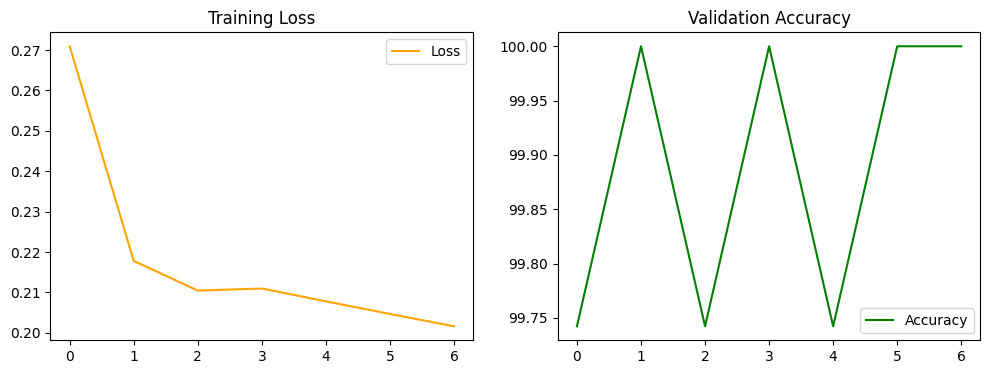

C:\Users\zisha\AppData\Local\Temp\ipykernel_19712\3961991787.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/fusion_ensemble.pt

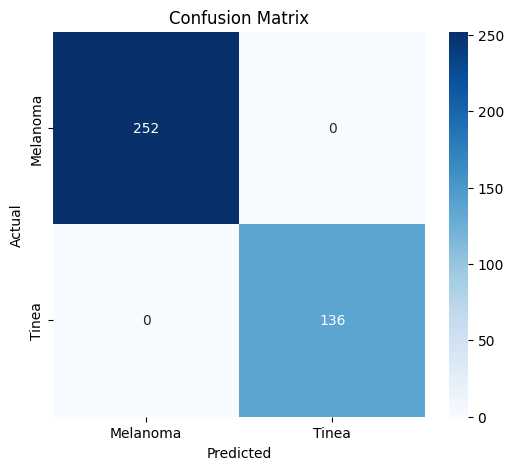

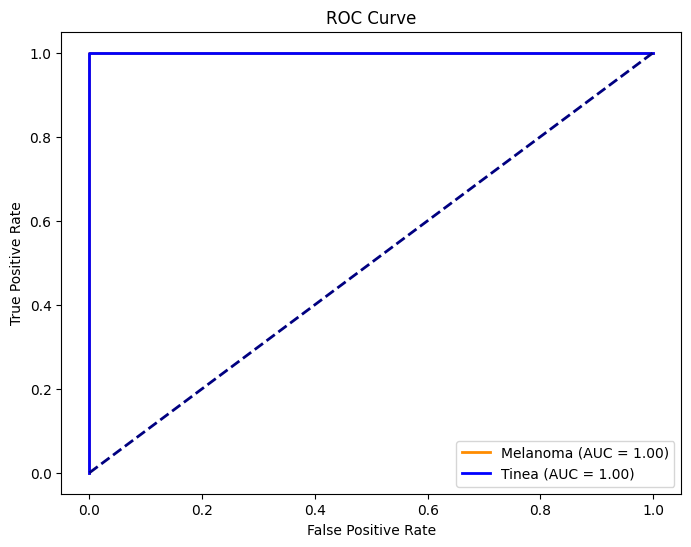

📋 Classification Report:
              precision    recall  f1-score   support

    Melanoma       1.00      1.00      1.00       252
       Tinea       1.00      1.00      1.00       136

    accuracy                           1.00       388
   macro avg       1.00      1.00      1.00       388
weighted avg       1.00      1.00      1.00       388

🔥 Generating Grad-CAM...


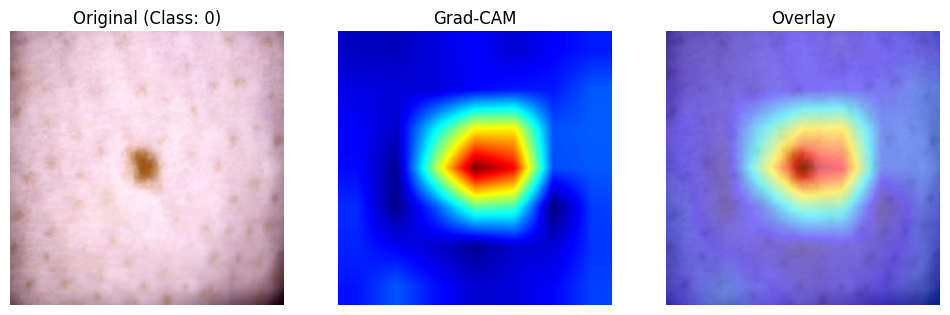

In [15]:
# 8. Evaluation & Visualization
os.makedirs('results', exist_ok=True)

# 8a. Metrics Plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Loss', color='orange')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['val_acc'], label='Accuracy', color='green')
plt.title('Validation Accuracy')
plt.legend()
plt.savefig('results/training_metrics.png')
plt.show()

# 8b. Load Best Model for Deep Eval
model.load_state_dict(torch.load('models/fusion_ensemble.pth'))
model.eval()

all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for x_res, x_inc, labels in val_loader:
        x_res, x_inc = x_res.to(device), x_inc.to(device)
        outputs = model(x_res, x_inc)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_probs.extend(probs.cpu().numpy())

all_probs = np.array(all_probs)

# 8c. Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Melanoma', 'Tinea'], yticklabels=['Melanoma', 'Tinea'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('results/confusion_matrix.png')
plt.show()

# 8d. ROC Curves (Added based on 03evaluation.py reference)
y_test_bin = label_binarize(all_labels, classes=[0, 1])
n_classes = y_test_bin.shape[1] if y_test_bin.shape[1] > 1 else 1

plt.figure(figsize=(8, 6))
# For binary case (Melanoma vs Tinea)
fpr, tpr, _ = roc_curve(all_labels, all_probs[:, 0], pos_label=0) # Melanoma is 0
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Melanoma (AUC = {roc_auc:.2f})')

fpr, tpr, _ = roc_curve(all_labels, all_probs[:, 1], pos_label=1) # Tinea is 1
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Tinea (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig('results/roc_curve.png')
plt.show()

# 8e. Classification Report
print("📋 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['Melanoma', 'Tinea']))

# 8f. Grad-CAM Visualization
print("🔥 Generating Grad-CAM...")
def generate_gradcam(model, dataset, device):
    gradients = []
    activations = []
    
    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])
        
    def forward_hook(module, input, output):
        activations.append(output)
        
    # Hook into ResNet Layer4
    target_layer = model.resnet_features[-2]
    handle_f = target_layer.register_forward_hook(forward_hook)
    handle_b = target_layer.register_full_backward_hook(backward_hook)
    
    # Get random sample
    idx = np.random.randint(0, len(dataset))
    x_res, x_inc, label = dataset[idx]
    x_res = x_res.unsqueeze(0).to(device)
    x_inc = x_inc.unsqueeze(0).to(device)
    label = torch.tensor([label]).to(device)
    
    model.zero_grad()
    output = model(x_res, x_inc)
    score = output[0, label.item()]
    score.backward()
    
    grad = gradients[0].cpu().data.numpy()[0]
    act = activations[0].cpu().data.numpy()[0]
    
    weights = np.mean(grad, axis=(1, 2))
    cam = np.zeros(act.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * act[i]
        
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224, 224))
    cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam) + 1e-8)
    
    handle_f.remove()
    handle_b.remove()
    
    # Plot
    img = x_res.cpu().numpy()[0].transpose(1, 2, 0)
    img = (img - img.min()) / (img.max() - img.min())
    
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = np.float32(heatmap) / 255
    
    overlay = heatmap + np.float32(img)
    overlay = overlay / np.max(overlay)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1); plt.imshow(img); plt.title(f"Original (Class: {label.item()})"); plt.axis('off')
    plt.subplot(1, 3, 2); plt.imshow(heatmap); plt.title("Grad-CAM"); plt.axis('off')
    plt.subplot(1, 3, 3); plt.imshow(overlay); plt.title("Overlay"); plt.axis('off')
    plt.savefig('results/gradcam_sample.png')
    plt.show()

try:
    generate_gradcam(model, val_ds, device)
except Exception as e:
    print(f"⚠️ Could not generate Grad-CAM: {e}")